In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import sampler
import time

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.shortcut = nn.Sequential()
        # 经过处理后的x要与x的维度相同(尺寸和深度)
        # 如果不相同，需要添加卷积+BN来变换为同一维度
        if stride != 1 or out_channel != self.expansion * in_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, self.expansion * out_channel,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channel)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # ResBlock
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

In [3]:
#  dataloader!
NUM = 49000
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM)))
cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM, 50000)))
cifar10_test = dset.CIFAR10('./datasets', train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [11]:
param = {}
param['lr'] = 1e-5
param['epochs'] = 30

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = ResNet18().to(device).train()
# print(model)
criterion = nn.CrossEntropyLoss()
optim = optim.Adam(model.parameters(), lr=param['lr'])
total_step = len(loader_train)

losses = []
accs = []

cuda


In [12]:
time_start = time.time()

# train
for epoch in range(param['epochs']):
    for i, (image, label) in enumerate(loader_train):
        image = image.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.long)

        scores = model(image)
        loss = criterion(scores, label)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, param['epochs'], i + 1, total_step, loss.item()))
            losses.append(loss.item())

    with torch.no_grad():
        correct, total = 0, 0
        model = model.eval()
        # test!
        for image, label in loader_val:
            image = image.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.long)
            output = model(image)
            _, pred = torch.max(output.data, 1)
            total += label.size(0)
            correct += (label == pred).sum().item()

        accuracy = correct/total
        accs.append(accuracy)
        print('Accuracy of the network on the test images: {:.2f} %'.format(100*accuracy))
    model = model.train()
time_end = time.time()

Epoch [1/30], Step [100/766], Loss: 0.0036
Epoch [1/30], Step [200/766], Loss: 0.0186
Epoch [1/30], Step [300/766], Loss: 0.0384
Epoch [1/30], Step [400/766], Loss: 0.0199
Epoch [1/30], Step [500/766], Loss: 0.1480
Epoch [1/30], Step [600/766], Loss: 0.0414
Epoch [1/30], Step [700/766], Loss: 0.0745
Accuracy of the network on the test images: 58.30 %
Epoch [2/30], Step [100/766], Loss: 0.0213
Epoch [2/30], Step [200/766], Loss: 0.0162
Epoch [2/30], Step [300/766], Loss: 0.0356
Epoch [2/30], Step [400/766], Loss: 0.0583
Epoch [2/30], Step [500/766], Loss: 0.0279
Epoch [2/30], Step [600/766], Loss: 0.0136
Epoch [2/30], Step [700/766], Loss: 0.0448
Accuracy of the network on the test images: 60.80 %
Epoch [3/30], Step [100/766], Loss: 0.0053
Epoch [3/30], Step [200/766], Loss: 0.0092
Epoch [3/30], Step [300/766], Loss: 0.0391
Epoch [3/30], Step [400/766], Loss: 0.0086
Epoch [3/30], Step [500/766], Loss: 0.0193
Epoch [3/30], Step [600/766], Loss: 0.0021
Epoch [3/30], Step [700/766], Loss: 

Time: 1949.33


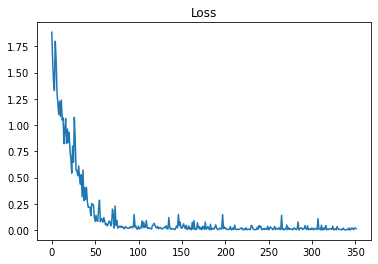

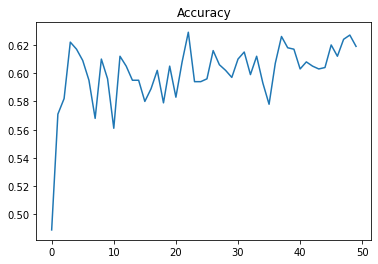

In [13]:
print('Time: {:.2f}'.format(time_end-time_start))
plt.figure()
plt.title('Loss')
plt.plot(losses)
plt.figure()
plt.title('Accuracy')
plt.plot(accs)
plt.show()

In [14]:
with torch.no_grad():
        correct, total = 0, 0
        model = model.eval()
        # test!
        for image, label in loader_test:
            image = image.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.long)
            output = model(image)
            _, pred = torch.max(output.data, 1)
            total += label.size(0)
            correct += (label == pred).sum().item()

        accuracy = correct/total
        print('Accuracy of the network on the test images: {:.2f} %'.format(100*accuracy))

Accuracy of the network on the test images: 61.09 %
